# Cross Validation Experimentation Platform

## Support Vector Regression

### Load libraries

In [2]:
#Load required packages
import pandas as pd
import numpy as np
from random import seed
from random import randrange
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.svm import SVR
import seaborn as sns; sns.set()

### Load dataset

Load the dataset here. Maintain the dataset name as df

In [147]:
#df = pd.read_csv('airfoil_self_noise.csv')
df = pd.read_csv('Concrete_Data.csv')

Confirm the number of rows and columns of the dataset.

In [148]:
df.shape

(1030, 9)

### Vary the dataset size

To vary the size of the dataset to be used for experimentation, specify the train_size e.g. 100 to use 100 samples. The train_size is the amount of data that will be used for the experimentation.

In [149]:
data1, data2 = train_test_split(df, train_size = 300, random_state=0)

In [150]:
data1.shape

(300, 9)

### Split the train set into k-folds

This function splits the dataset into k equal folds.

In [151]:

def dataset_splitter(dataset, folds=3):
    "A custom function that splits a dataset into k equal folds"
    seed(30)
    splits_list = list()    
    fold_size = int(len(dataset) / folds)
    for i in range(folds):        
        fold = pd.DataFrame(columns = dataset.columns)
        while len(fold) < fold_size:
            if len(dataset) == 0:
                break
            index = randrange(len(dataset))
            selected_row = pd.DataFrame(dataset.loc[(dataset.index == index)])
            fold = pd.concat([fold, selected_row])
            dataset = dataset.reset_index(drop=True)
        splits_list.append(fold)
    return splits_list

#Use function to split a dataset into 10 folds.   
splits = dataset_splitter(data1, 10)
for i in splits:
    print(i.shape)
    

(30, 9)
(30, 9)
(30, 9)
(30, 9)
(30, 9)
(30, 9)
(30, 9)
(30, 9)
(30, 9)
(30, 9)


Explore a given fold

In [153]:
splits[3].head(5)

,Cement,BF.Slag,Flyash,Water,Superp,Coarse,Fine,Age,Strength
151,173.5,50.1,173.5,164.8,6.5,1006.2,793.5,3,23.08
270,251.4,0.0,118.3,192.9,5.8,1043.6,754.3,14,20.73
164,139.6,209.4,0.0,192.0,0.0,1047.0,806.9,180,44.21
10,165.0,128.5,132.1,175.1,8.1,1005.8,746.6,56,53.72
96,425.0,106.3,0.0,153.5,16.5,852.1,887.1,56,64.30


### Train, Validation and Test Sets

Using the 10 splits we created above
- Trainng set: 80% (split 0 to split 7)
- Reduced Training set: 70% (split 0 split 6)
- Validation set: 10% (split 7)
- Testing set: 20% (split 8 and split 9


In [154]:
#Create Train set - to be for CV-based estimate
training_set = pd.DataFrame(columns = splits[0].columns)
training_set = pd.concat([training_set, splits[0], splits[1], splits[2], splits[3], splits[4], splits[5], splits[6],splits[7]])

Xtraining = training_set.iloc[:, 0:(len(training_set.columns)-1)]
ytraining = training_set.iloc[:, len(training_set.columns)-1]

#Create reduced Train set - to be used for CV-based estimate
rtraining_set = pd.DataFrame(columns = splits[0].columns)
rtraining_set = pd.concat([rtraining_set, splits[0], splits[1], splits[2], splits[3], splits[4], splits[5], splits[6]])

Xrtraining = rtraining_set.iloc[:, 0:(len(rtraining_set.columns)-1)]
yrtraining = rtraining_set.iloc[:, len(rtraining_set.columns)-1]


#Create Validation set - to validate model trained on rtraining_set
validation_set = splits[7]
Xvalidation = validation_set.iloc[:, 0:(len(validation_set.columns)-1)]
yvalidation = validation_set.iloc[:, len(validation_set.columns)-1]

#Create test set - to evaluate model trained on rtraining_set and validated on validation_set
testing_set = pd.DataFrame(columns = splits[0].columns)
testing_set = pd.concat([testing_set, splits[8], splits[9]])
Xtesting = testing_set.iloc[:, 0:(len(testing_set.columns)-1)]
ytesting = testing_set.iloc[:, len(testing_set.columns)-1]

In [155]:
print('Training set:', training_set.shape)
print('Reduced training set:', rtraining_set.shape)
print('Validation set:', validation_set.shape)
print('Testing set:', testing_set.shape)

Training set: (240, 9)
Reduced training set: (210, 9)
Validation set: (30, 9)
Testing set: (60, 9)


### Run: Train, Validate, Test with SVR

Question is, if one is to choose a model, which strategy would they use?
CV-based alone?
+ External Validation?


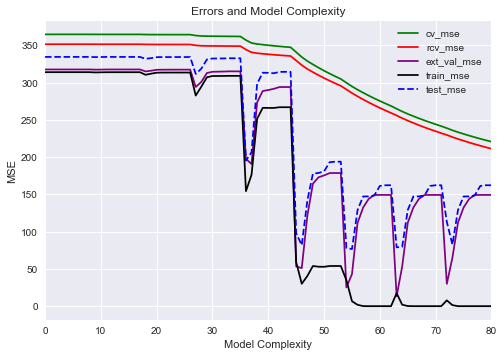

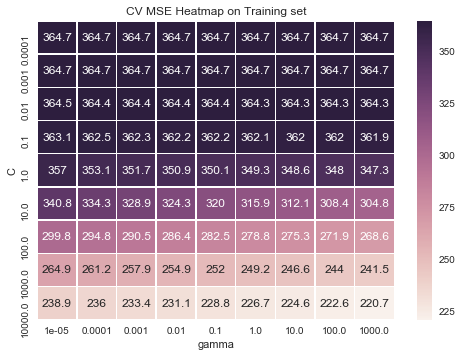

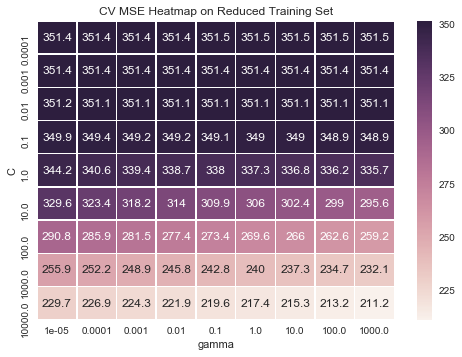

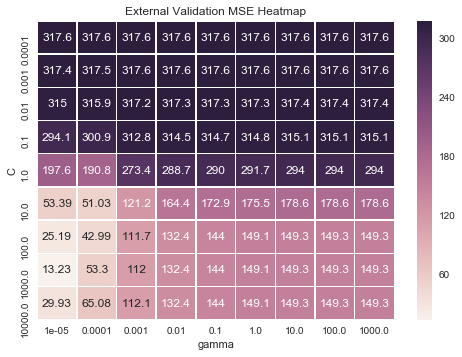

C: 1000.0 gamma: 1e-05 MSE: 13.2302445497


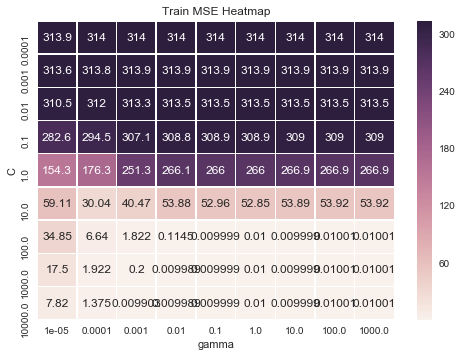

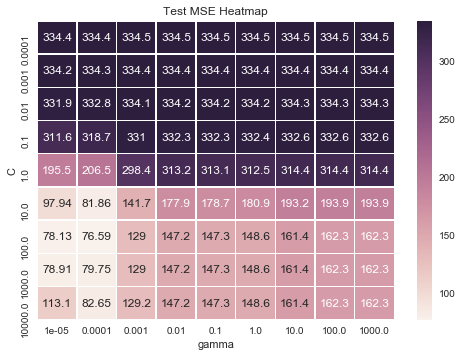

In [156]:
#split training subsets into k folds
folds = dataset_splitter(training_set, 5) #split the training subset fo 5-fold CV
rfolds = dataset_splitter(rtraining_set, 5) #split the rtraining subset fo 5-fold CV

#parameter values
C_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
gamma_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

#define variables and lists
c_out =[]
gamma_out= []
cv_mse_out = []
cv_iter_mse = []
rcv_mse_out = []
rcv_iter_mse = []
train_mse_out = []
ext_val_mse_out =[]
test_mse_out = []

#train, validate and test
for C in C_values:
    for gamma in gamma_values: 
        model = SVR(kernel='rbf', C = C, gamma = gamma)  
        
    #produce training error on rtraining
        model.fit(Xrtraining, yrtraining)
        pred_on_train = model.predict(Xrtraining)
        train_mse = metrics.mean_squared_error(yrtraining, pred_on_train)
        train_mse_out.append(train_mse)
    #end training error
        
    ##k-fold CV on training_set
        for i in range(len(folds)):
            test_set = folds[i]    
            Xtest = test_set.iloc[:, 0:(len(test_set.columns)-1)]
            ytest = test_set.iloc[:, len(test_set.columns)-1]   
    
            train_set = pd.DataFrame(columns = folds[0].columns)    
            for j in range(len(folds)):
                if j == i:
                    continue
                train_set = pd.concat([train_set, folds[j]])
            Xtrain = train_set.iloc[:, 0:(len(train_set.columns)-1)]
            ytrain = train_set.iloc[:, len(train_set.columns)-1]        
            
            model.fit(Xtrain, ytrain)
            pred_ytest = model.predict(Xtest)
            iter_mse = metrics.mean_squared_error(ytest, pred_ytest)    
            cv_iter_mse.append(iter_mse)
            cv_mse = np.mean(cv_iter_mse)
        cv_mse_out.append(cv_mse)   
    ## end k-fold CV
    
    ## k-fold CV on rtraining_set
        for i in range(len(rfolds)):
            rtest_set = rfolds[i]    
            Xrtest = rtest_set.iloc[:, 0:(len(rtest_set.columns)-1)]
            yrtest = rtest_set.iloc[:, len(rtest_set.columns)-1]   
    
            rtrain_set = pd.DataFrame(columns = rfolds[0].columns)    
            for j in range(len(rfolds)):
                if j == i:
                    continue
                rtrain_set = pd.concat([rtrain_set, rfolds[j]])
            Xrtrain = rtrain_set.iloc[:, 0:(len(rtrain_set.columns)-1)]
            yrtrain = rtrain_set.iloc[:, len(rtrain_set.columns)-1]        
            
            model.fit(Xrtrain, yrtrain)
            pred_yrtest = model.predict(Xrtest)
            riter_mse = metrics.mean_squared_error(yrtest, pred_yrtest)    
            rcv_iter_mse.append(riter_mse)
            rcv_mse = np.mean(rcv_iter_mse)
        rcv_mse_out.append(rcv_mse)   
    ## end k-fold CV
    
    ## external validation
        model.fit(Xrtraining, yrtraining)
        predict_ext_val = model.predict(Xvalidation)
        ext_val_mse = metrics.mean_squared_error(yvalidation, predict_ext_val)
        ext_val_mse_out.append(ext_val_mse)
    ## end external validation
    
    ##testing on unseen data
        model.fit(Xrtraining, yrtraining)
        pred_on_test = model.predict(Xtesting)
        test_mse = metrics.mean_squared_error(ytesting, pred_on_test)
        test_mse_out.append(test_mse)
    ##end testing on unseen data    
        
        #re-capture parameters used in iteration
        c_out.append(C)
        gamma_out.append(gamma)
             
#create dictionary of parameters and mses then convert into a dataframe
outputs = {'C': c_out, 
           'gamma': gamma_out, 
           'cv_mse': cv_mse_out, 
           'rcv_mse': rcv_mse_out,
           'train_mse': train_mse_out,
           'ext_val_mse': ext_val_mse_out,
           'test_mse': test_mse_out           
          }
outputs = pd.DataFrame(outputs) 
outputs2= outputs #keep data for plotting before pivoting 

#store best parameters and score
best_score = outputs['ext_val_mse'].min()
best_score_rows = outputs.loc[(outputs['ext_val_mse'] == best_score)]
if len(best_score_rows.index) == 1:
    best_parameters = best_score_rows
elif len(best_score_rows.index) > 1:
    best_parameters = best_score_rows.loc[best_score_rows['C'] == best_score_rows['C'].min()] 

best_C = best_parameters.iloc[0]['C']
best_gamma = best_parameters.iloc[0]['gamma']
best_mse = best_parameters.iloc[0]['ext_val_mse']

#plot line graph
ax = plt.gca()
#plt.ylim((-5, 100))
outputs2.plot(kind='line', y='cv_mse',ax=ax, color ='green')
outputs2.plot(kind='line', y='rcv_mse',ax=ax, color ='red')
outputs2.plot(kind='line', y='ext_val_mse',ax=ax, color = 'purple')
outputs2.plot(kind='line', y='train_mse',ax=ax, color ='black')
outputs2.plot(linestyle='dashed', y='test_mse', ax=ax, color ='blue')
plt.title('Errors and Model Complexity')
plt.xlabel('Model Complexity')
plt.ylabel('MSE')
plt.show()

#plot heatmaps
outputs_cv_train = outputs.pivot('C', 'gamma', 'cv_mse')
sns.heatmap(outputs_cv_train, annot=True, linewidths=.5, fmt='.4g')
plt.title("CV MSE Heatmap on Training set")
plt.show()

outputs_rcv_train = outputs.pivot('C', 'gamma', 'rcv_mse')
sns.heatmap(outputs_rcv_train, annot=True, linewidths=.5, fmt='.4g')
plt.title("CV MSE Heatmap on Reduced Training Set")
plt.show()

outputs_ext_val = outputs.pivot('C', 'gamma', 'ext_val_mse')
sns.heatmap(outputs_ext_val, annot=True, linewidths=.5, fmt='.4g')
plt.title("External Validation MSE Heatmap")
plt.show()

print('C:', best_C, 'gamma:', best_gamma, 'MSE:', best_mse)

outputs_ext_valid = outputs.pivot('C', 'gamma', 'train_mse')
sns.heatmap(outputs_ext_valid, annot=True, linewidths=.5, fmt='.4g')
plt.title("Train MSE Heatmap")
plt.show()

outputs_cv_train = outputs.pivot('C', 'gamma', 'test_mse')
sns.heatmap(outputs_cv_train, annot=True, linewidths=.5, fmt='.4g')
plt.title("Test MSE Heatmap")
plt.show()


### The code below is not part of the Experimentation Platform, but was used for capturing results from the repeated experiment with different seeds. The outputs were written to file and then called again to obtain the averages. The seeds used were 10, 20 and 30. Ech individual block to be run with the Charts creation blosk at the bottom to produce averaged plots.

In [6]:
#write to CSV
#outputs2.to_csv("concrete900seed10.csv")

In [7]:
#900 samples

#Combine 3 sets
concrete900seed10 = pd.read_csv("outputs/concrete900seed10.csv")
concrete900seed20 = pd.read_csv("outputs/concrete900seed20.csv")
concrete900seed30 = pd.read_csv("outputs/concrete900seed30.csv")
concrete900_avg = pd.DataFrame(columns = concrete900seed10.columns)

concrete900_avg["C"] = concrete900seed10["C"]
concrete900_avg["gamma"] = concrete900seed10["gamma"]
concrete900_avg["cv_mse"] = (concrete900seed10["cv_mse"] + concrete900seed20["cv_mse"] + concrete900seed30["cv_mse"])/3
concrete900_avg["ext_val_mse"] = (concrete900seed10["ext_val_mse"] + concrete900seed20["ext_val_mse"] + concrete900seed30["ext_val_mse"])/3
concrete900_avg["train_mse"] = (concrete900seed10["train_mse"] + concrete900seed20["train_mse"] + concrete900seed30["train_mse"])/3
concrete900_avg["rcv_mse"] = (concrete900seed10["rcv_mse"] + concrete900seed20["rcv_mse"] + concrete900seed30["rcv_mse"])/3
concrete900_avg["test_mse"] = (concrete900seed10["test_mse"] + concrete900seed20["test_mse"] + concrete900seed30["test_mse"])/3
#concrete900_avg

outputs = concrete900_avg
outputs2 = outputs
dsname = "Concrete"
nsamples = 900
nsamples = str(nsamples)

In [8]:
#600 samples

#Combine 3 sets
concrete600seed10 = pd.read_csv("outputs/concrete600seed10.csv")
concrete600seed20 = pd.read_csv("outputs/concrete600seed20.csv")
concrete600seed30 = pd.read_csv("outputs/concrete600seed30.csv")
concrete600_avg = pd.DataFrame(columns = concrete600seed10.columns)

concrete600_avg["C"] = concrete600seed10["C"]
concrete600_avg["gamma"] = concrete600seed10["gamma"]
concrete600_avg["cv_mse"] = (concrete600seed10["cv_mse"] + concrete600seed20["cv_mse"] + concrete600seed30["cv_mse"])/3
concrete600_avg["ext_val_mse"] = (concrete600seed10["ext_val_mse"] + concrete600seed20["ext_val_mse"] + concrete600seed30["ext_val_mse"])/3
concrete600_avg["train_mse"] = (concrete600seed10["train_mse"] + concrete600seed20["train_mse"] + concrete600seed30["train_mse"])/3
concrete600_avg["rcv_mse"] = (concrete600seed10["rcv_mse"] + concrete600seed20["rcv_mse"] + concrete600seed30["rcv_mse"])/3
concrete600_avg["test_mse"] = (concrete600seed10["test_mse"] + concrete600seed20["test_mse"] + concrete600seed30["test_mse"])/3
#concrete600_avg

outputs = concrete600_avg
outputs2 = outputs
dsname = "Concrete"
nsamples = 600
nsamples = str(nsamples)

In [9]:
#300 samples

#Combine 3 sets
concrete300seed10 = pd.read_csv("outputs/concrete300seed10.csv")
concrete300seed20 = pd.read_csv("outputs/concrete300seed20.csv")
concrete300seed30 = pd.read_csv("outputs/concrete300seed30.csv")
concrete300_avg = pd.DataFrame(columns = concrete300seed10.columns)

concrete300_avg["C"] = concrete300seed10["C"]
concrete300_avg["gamma"] = concrete300seed10["gamma"]
concrete300_avg["cv_mse"] = (concrete300seed10["cv_mse"] + concrete300seed20["cv_mse"] + concrete300seed30["cv_mse"])/3
concrete300_avg["ext_val_mse"] = (concrete300seed10["ext_val_mse"] + concrete300seed20["ext_val_mse"] + concrete300seed30["ext_val_mse"])/3
concrete300_avg["train_mse"] = (concrete300seed10["train_mse"] + concrete300seed20["train_mse"] + concrete300seed30["train_mse"])/3
concrete300_avg["rcv_mse"] = (concrete300seed10["rcv_mse"] + concrete300seed20["rcv_mse"] + concrete300seed30["rcv_mse"])/3
concrete300_avg["test_mse"] = (concrete300seed10["test_mse"] + concrete300seed20["test_mse"] + concrete300seed30["test_mse"])/3
#concrete300_avg

outputs = concrete300_avg
outputs2 = outputs
dsname = "Concrete"
nsamples = 300
nsamples = str(nsamples)

In [10]:
#100 samples

#Combine 3 sets
concrete100seed10 = pd.read_csv("outputs/concrete100seed10.csv")
concrete100seed20 = pd.read_csv("outputs/concrete100seed20.csv")
concrete100seed30 = pd.read_csv("outputs/concrete100seed30.csv")
concrete100_avg = pd.DataFrame(columns = concrete100seed10.columns)

concrete100_avg["C"] = concrete100seed10["C"]
concrete100_avg["gamma"] = concrete100seed10["gamma"]
concrete100_avg["cv_mse"] = (concrete100seed10["cv_mse"] + concrete100seed20["cv_mse"] + concrete100seed30["cv_mse"])/3
concrete100_avg["ext_val_mse"] = (concrete100seed10["ext_val_mse"] + concrete100seed20["ext_val_mse"] + concrete100seed30["ext_val_mse"])/3
concrete100_avg["train_mse"] = (concrete100seed10["train_mse"] + concrete100seed20["train_mse"] + concrete100seed30["train_mse"])/3
concrete100_avg["rcv_mse"] = (concrete100seed10["rcv_mse"] + concrete100seed20["rcv_mse"] + concrete100seed30["rcv_mse"])/3
concrete100_avg["test_mse"] = (concrete100seed10["test_mse"] + concrete100seed20["test_mse"] + concrete100seed30["test_mse"])/3
#concrete100_avg

outputs = concrete100_avg
outputs2 = outputs
dsname = "Concrete"
nsamples = 100
nsamples = str(nsamples)

In [11]:
#100 samples

#Combine 3 sets
airfoil100seed10 = pd.read_csv("outputs/airfoil100seed10.csv")
airfoil100seed20 = pd.read_csv("outputs/airfoil100seed20.csv")
airfoil100seed30 = pd.read_csv("outputs/airfoil100seed30.csv")
airfoil100_avg = pd.DataFrame(columns = airfoil100seed10.columns)

airfoil100_avg["C"] = airfoil100seed10["C"]
airfoil100_avg["gamma"] = airfoil100seed10["gamma"]
airfoil100_avg["cv_mse"] = (airfoil100seed10["cv_mse"] + airfoil100seed20["cv_mse"] + airfoil100seed30["cv_mse"])/3
airfoil100_avg["ext_val_mse"] = (airfoil100seed10["ext_val_mse"] + airfoil100seed20["ext_val_mse"] + airfoil100seed30["ext_val_mse"])/3
airfoil100_avg["train_mse"] = (airfoil100seed10["train_mse"] + airfoil100seed20["train_mse"] + airfoil100seed30["train_mse"])/3
airfoil100_avg["rcv_mse"] = (airfoil100seed10["rcv_mse"] + airfoil100seed20["rcv_mse"] + airfoil100seed30["rcv_mse"])/3
airfoil100_avg["test_mse"] = (airfoil100seed10["test_mse"] + airfoil100seed20["test_mse"] + airfoil100seed30["test_mse"])/3
#airfoil100_avg

outputs = airfoil100_avg
outputs2 = outputs
dsname = "Airfoil"
nsamples = 100
nsamples = str(nsamples)

In [12]:
#300 samples

#Combine 3 sets
airfoil300seed10 = pd.read_csv("outputs/airfoil300seed10.csv")
airfoil300seed20 = pd.read_csv("outputs/airfoil300seed20.csv")
airfoil300seed30 = pd.read_csv("outputs/airfoil300seed30.csv")
airfoil300_avg = pd.DataFrame(columns = airfoil300seed10.columns)

airfoil300_avg["C"] = airfoil300seed10["C"]
airfoil300_avg["gamma"] = airfoil300seed10["gamma"]
airfoil300_avg["cv_mse"] = (airfoil300seed10["cv_mse"] + airfoil300seed20["cv_mse"] + airfoil300seed30["cv_mse"])/3
airfoil300_avg["ext_val_mse"] = (airfoil300seed10["ext_val_mse"] + airfoil300seed20["ext_val_mse"] + airfoil300seed30["ext_val_mse"])/3
airfoil300_avg["train_mse"] = (airfoil300seed10["train_mse"] + airfoil300seed20["train_mse"] + airfoil300seed30["train_mse"])/3
airfoil300_avg["rcv_mse"] = (airfoil300seed10["rcv_mse"] + airfoil300seed20["rcv_mse"] + airfoil300seed30["rcv_mse"])/3
airfoil300_avg["test_mse"] = (airfoil300seed10["test_mse"] + airfoil300seed20["test_mse"] + airfoil300seed30["test_mse"])/3
#airfoil300_avg

outputs = airfoil300_avg
outputs2 = outputs
dsname = "Airfoil"
nsamples = 300
nsamples = str(nsamples)

In [13]:
#600 samples

#Combine 3 sets
airfoil600seed10 = pd.read_csv("outputs/airfoil600seed10.csv")
airfoil600seed20 = pd.read_csv("outputs/airfoil600seed20.csv")
airfoil600seed30 = pd.read_csv("outputs/airfoil600seed30.csv")
airfoil600_avg = pd.DataFrame(columns = airfoil600seed10.columns)

airfoil600_avg["C"] = airfoil600seed10["C"]
airfoil600_avg["gamma"] = airfoil600seed10["gamma"]
airfoil600_avg["cv_mse"] = (airfoil600seed10["cv_mse"] + airfoil600seed20["cv_mse"] + airfoil600seed30["cv_mse"])/3
airfoil600_avg["ext_val_mse"] = (airfoil600seed10["ext_val_mse"] + airfoil600seed20["ext_val_mse"] + airfoil600seed30["ext_val_mse"])/3
airfoil600_avg["train_mse"] = (airfoil600seed10["train_mse"] + airfoil600seed20["train_mse"] + airfoil600seed30["train_mse"])/3
airfoil600_avg["rcv_mse"] = (airfoil600seed10["rcv_mse"] + airfoil600seed20["rcv_mse"] + airfoil600seed30["rcv_mse"])/3
airfoil600_avg["test_mse"] = (airfoil600seed10["test_mse"] + airfoil600seed20["test_mse"] + airfoil600seed30["test_mse"])/3
#airfoil600_avg

outputs = airfoil600_avg
outputs2 = outputs
dsname = "Airfoil"
nsamples = 600
nsamples = str(nsamples)

In [15]:
#900 samples

#Combine 3 sets
airfoil900seed10 = pd.read_csv("outputs/airfoil900seed10.csv")
airfoil900seed20 = pd.read_csv("outputs/airfoil900seed20.csv")
airfoil900seed30 = pd.read_csv("outputs/airfoil900seed30.csv")
airfoil900_avg = pd.DataFrame(columns = airfoil900seed10.columns)

airfoil900_avg["C"] = airfoil900seed10["C"]
airfoil900_avg["gamma"] = airfoil900seed10["gamma"]
airfoil900_avg["cv_mse"] = (airfoil900seed10["cv_mse"] + airfoil900seed20["cv_mse"] + airfoil900seed30["cv_mse"])/3
airfoil900_avg["ext_val_mse"] = (airfoil900seed10["ext_val_mse"] + airfoil900seed20["ext_val_mse"] + airfoil900seed30["ext_val_mse"])/3
airfoil900_avg["train_mse"] = (airfoil900seed10["train_mse"] + airfoil900seed20["train_mse"] + airfoil900seed30["train_mse"])/3
airfoil900_avg["rcv_mse"] = (airfoil900seed10["rcv_mse"] + airfoil900seed20["rcv_mse"] + airfoil900seed30["rcv_mse"])/3
airfoil900_avg["test_mse"] = (airfoil900seed10["test_mse"] + airfoil900seed20["test_mse"] + airfoil900seed30["test_mse"])/3
#airfoil900_avg

outputs = airfoil900_avg
outputs2 = outputs
dsname = "Airfoil"
nsamples = 900
nsamples = str(nsamples)


### Create Charts with Averaged Values

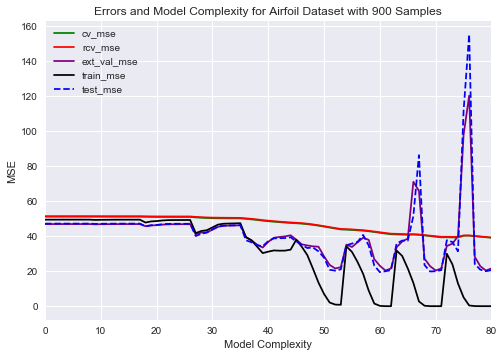

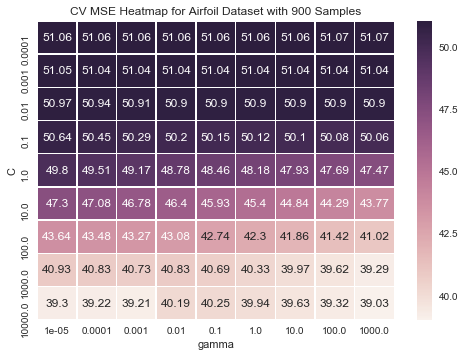

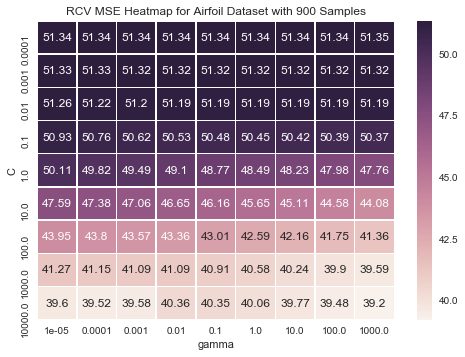

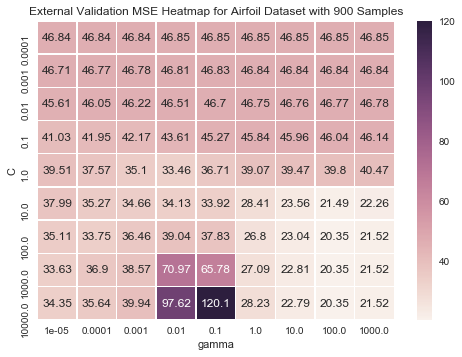

C: 100.0 gamma: 100.0 MSE: 20.3523685833


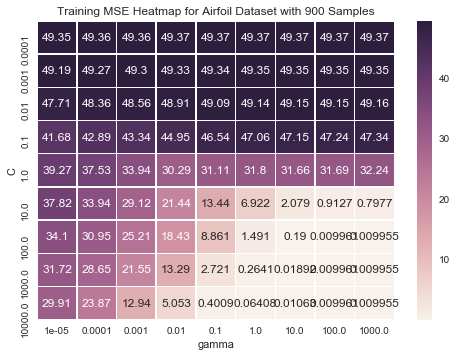

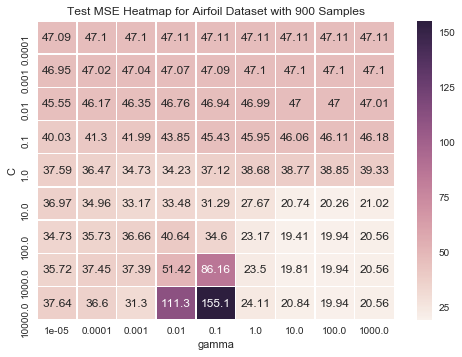

In [16]:

#store best parameters and score
best_score = outputs['ext_val_mse'].min()
best_score_rows = outputs.loc[(outputs['ext_val_mse'] == best_score)]
if len(best_score_rows.index) == 1:
    best_parameters = best_score_rows
elif len(best_score_rows.index) > 1:
    best_parameters = best_score_rows.loc[best_score_rows['C'] == best_score_rows['C'].min()] 

best_C = best_parameters.iloc[0]['C']
best_gamma = best_parameters.iloc[0]['gamma']
best_mse = best_parameters.iloc[0]['ext_val_mse']

#plot line graph
ax = plt.gca()
#plt.ylim((-5, 100))
outputs2.plot(kind='line', y='cv_mse',ax=ax, color ='green')
outputs2.plot(kind='line', y='rcv_mse',ax=ax, color ='red')
outputs2.plot(kind='line', y='ext_val_mse',ax=ax, color = 'purple')
outputs2.plot(kind='line', y='train_mse',ax=ax, color ='black')
outputs2.plot(linestyle='dashed', y='test_mse', ax=ax, color ='blue')
plt.title("Errors and Model Complexity for "+ dsname +" Dataset with "+ nsamples +" Samples")
plt.xlabel('Model Complexity')
plt.ylabel('MSE')
plt.show()

#plot heatmap
outputs_cv_train = outputs.pivot('C', 'gamma', 'cv_mse')
sns.heatmap(outputs_cv_train, annot=True, linewidths=.5, fmt='.4g')
plt.title("CV MSE Heatmap for "+ dsname +" Dataset with "+ nsamples+ " Samples")
plt.show()

outputs_rcv_train = outputs.pivot('C', 'gamma', 'rcv_mse')
sns.heatmap(outputs_rcv_train, annot=True, linewidths=.5, fmt='.4g')
plt.title("RCV MSE Heatmap for "+ dsname +" Dataset with "+ nsamples +" Samples")
plt.show()

outputs_ext_valid = outputs.pivot('C', 'gamma', 'ext_val_mse')
sns.heatmap(outputs_ext_valid, annot=True, linewidths=.5, fmt='.4g')
plt.title("External Validation MSE Heatmap for "+ dsname +" Dataset with "+ nsamples +" Samples")
plt.show()

print('C:', best_C, 'gamma:', best_gamma, 'MSE:', best_mse)

outputs_train_mse = outputs.pivot('C', 'gamma', 'train_mse')
sns.heatmap(outputs_train_mse, annot=True, linewidths=.5, fmt='.4g')
plt.title("Training MSE Heatmap for "+ dsname +" Dataset with "+ nsamples +" Samples")
plt.show()

outputs_test_mse = outputs.pivot('C', 'gamma', 'test_mse')
sns.heatmap(outputs_test_mse, annot=True, linewidths=.5, fmt='.4g')
plt.title("Test MSE Heatmap for "+ dsname +" Dataset with "+ nsamples +" Samples")
plt.show()

